In [1]:
import findspark
findspark.init()


In [31]:
import pyspark.sql.functions as f
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext


sc = SparkContext(conf=SparkConf().setAppName("MyApp").setMaster("local"))
sqlContext = SQLContext(sc)

train_data=sc.textFile("C:/Users/lamisa/Desktop/titanic/train.csv")

In [4]:
def mappingFunc(inp):
    data=inp.split(",")
    
    for i in range(0,len(data)):
        if not data[i]:
            data[i]=None
    
    return tuple(data)

def convToFloat(x):
    if x is not None:
        return float(x)
        
header1=train_data.first()
#print(header)
train_data_final=train_data.filter(lambda x: x!=header1)
train_data_final=train_data_final.map(lambda x: mappingFunc(x))
train_data_final=train_data_final.map(lambda x: (x[0],int(x[1]),int(x[2]),x[3]+x[4],x[5],convToFloat(x[6]),x[7],x[8],x[9],float(x[10]),x[11],x[12]))

#train_data_final.take(5)

In [5]:
shemaTitanic=StructType([StructField('PassengerId', StringType(),nullable=True),StructField('Survived', IntegerType(),nullable=True),
StructField('pClass', IntegerType(),nullable=True), StructField('Name', StringType(),nullable=True),
StructField('Sex',StringType(),nullable=True), StructField('Age',DoubleType(),nullable=True), StructField('SibSp',StringType(),nullable=True),StructField('Parch',StringType(),nullable=True),
StructField('Ticket',StringType(),nullable=True),StructField('Fare',DoubleType(),nullable=True),StructField('Cabin',StringType(),nullable=True),StructField('Embarked',StringType(),nullable=True)])


people_df = sqlContext.createDataFrame(train_data_final, shemaTitanic)
#people_df.registerTempTable("Titanic")

In [6]:
#people_df.printSchema()
people_df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|pClass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|"Braund Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|"Cumings Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|"Heikkinen Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|"Futrelle Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|"Allen Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|   "Moran Mr. James"|  male|null|    0|    0|      

In [7]:
#dimensions of data
print((people_df.count(),len(people_df.columns)))
people_df.select('Fare','Age','pClass').describe().show()

(891, 12)
+-------+-----------------+------------------+------------------+
|summary|             Fare|               Age|            pClass|
+-------+-----------------+------------------+------------------+
|  count|              891|               714|               891|
|   mean| 32.2042079685746| 29.69911764705882| 2.308641975308642|
| stddev|49.69342859718089|14.526497332334035|0.8360712409770491|
|    min|              0.0|              0.42|                 1|
|    max|         512.3292|              80.0|                 3|
+-------+-----------------+------------------+------------------+



In [8]:
#missing value counts in original dataset
data_missing = people_df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in people_df.columns])
data_missing.show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|pClass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+

+------+-----+
|   Sex|count|
+------+-----+
|female|  314|
|  male|  577|
+------+-----+

113


In [65]:
#Rename columns
#ignoring parch, sibsp, ticket, and cabin column for the time
new_df=people_df.select('PassengerId',f.col('Survived').alias('label'),'pClass','Sex','Age','Fare','Embarked')
new_df.show(2)

+-----------+-----+------+------+----+-------+--------+
|PassengerId|label|pClass|   Sex| Age|   Fare|Embarked|
+-----------+-----+------+------+----+-------+--------+
|          1|    0|     3|  male|22.0|   7.25|       S|
|          2|    1|     1|female|38.0|71.2833|       C|
+-----------+-----+------+------+----+-------+--------+
only showing top 2 rows



Mean age: 29.69911764705882
Median age: 28.0
Minimum age: 0.42
Maximum age: 80.0


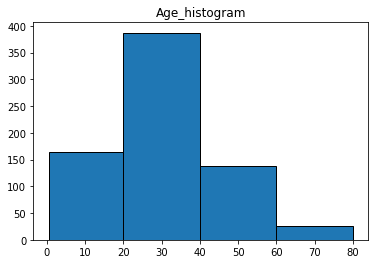

In [66]:
#fill the NULL values by exploring the columns
#examine 'age' column

age_array=np.array(new_df.select('Age').dropna().collect())
mean_age=np.mean(age_array)
median_age=np.median(age_array)
max_age=np.max(age_array)
min_age=np.min(age_array)
print('Mean age: ' + str(mean_age))
print('Median age: ' + str(median_age))
print('Minimum age: ' + str(min_age))
print('Maximum age: ' + str(max_age))

plt.hist(age_array, bins = [min_age,20,40,60,max_age],ec='black') 
plt.title("Age_histogram") 
plt.show()

In [70]:
#fill null values with mean age value
new_df=new_df.fillna({'Age':round(mean_age,3)})
new_df.show()


+-----------+-----+------+------+------+-------+--------+
|PassengerId|label|pClass|   Sex|   Age|   Fare|Embarked|
+-----------+-----+------+------+------+-------+--------+
|          1|    0|     3|  male|  22.0|   7.25|       S|
|          2|    1|     1|female|  38.0|71.2833|       C|
|          3|    1|     3|female|  26.0|  7.925|       S|
|          4|    1|     1|female|  35.0|   53.1|       S|
|          5|    0|     3|  male|  35.0|   8.05|       S|
|          6|    0|     3|  male|29.699| 8.4583|       Q|
|          7|    0|     1|  male|  54.0|51.8625|       S|
|          8|    0|     3|  male|   2.0| 21.075|       S|
|          9|    1|     3|female|  27.0|11.1333|       S|
|         10|    1|     2|female|  14.0|30.0708|       C|
|         11|    1|     3|female|   4.0|   16.7|       S|
|         12|    1|     1|female|  58.0|  26.55|       S|
|         13|    0|     3|  male|  20.0|   8.05|       S|
|         14|    0|     3|  male|  39.0| 31.275|       S|
|         15| 

<ipython-input-71-1a942b2808a0>:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  ax.pie(emb_count, labels = emb_array,autopct='%1.2f%%')


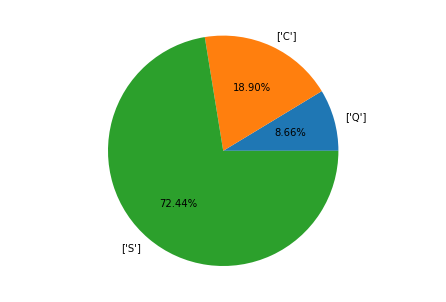

In [71]:
#examine Embarked column

emb_df=new_df.groupBy('Embarked').count().dropna()
emb_array=np.array(emb_df.select('Embarked').collect())
emb_count=np.array(emb_df.select('Count').collect())

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(emb_count, labels = emb_array,autopct='%1.2f%%')
plt.show()

In [73]:
#fill null values in 'Embarked' Column with 'S'
new_df=new_df.fillna({'Embarked':'S'})
new_df.show()

+-----------+-----+------+------+------+-------+--------+
|PassengerId|label|pClass|   Sex|   Age|   Fare|Embarked|
+-----------+-----+------+------+------+-------+--------+
|          1|    0|     3|  male|  22.0|   7.25|       S|
|          2|    1|     1|female|  38.0|71.2833|       C|
|          3|    1|     3|female|  26.0|  7.925|       S|
|          4|    1|     1|female|  35.0|   53.1|       S|
|          5|    0|     3|  male|  35.0|   8.05|       S|
|          6|    0|     3|  male|29.699| 8.4583|       Q|
|          7|    0|     1|  male|  54.0|51.8625|       S|
|          8|    0|     3|  male|   2.0| 21.075|       S|
|          9|    1|     3|female|  27.0|11.1333|       S|
|         10|    1|     2|female|  14.0|30.0708|       C|
|         11|    1|     3|female|   4.0|   16.7|       S|
|         12|    1|     1|female|  58.0|  26.55|       S|
|         13|    0|     3|  male|  20.0|   8.05|       S|
|         14|    0|     3|  male|  39.0| 31.275|       S|
|         15| 

In [74]:
# examine new_df for missing value

new_df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in new_df.columns]).show()


+-----------+-----+------+---+---+----+--------+
|PassengerId|label|pClass|Sex|Age|Fare|Embarked|
+-----------+-----+------+---+---+----+--------+
|          0|    0|     0|  0|  0|   0|       0|
+-----------+-----+------+---+---+----+--------+



In [75]:
#building pipeline
cate_features=['Sex','Embarked']
conti_features=['Age','Fare','pClass']
stages=[]

for featureCol in cate_features:
    stringIndexer=StringIndexer(inputCol=featureCol, outputCol=featureCol+"Indexed")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()],outputCols=[featureCol + "classVec"])
    stages += [stringIndexer, encoder]

assemblerInput = [x+'classVec' for x in cate_features]+conti_features
    
assembler = VectorAssembler(inputCols=assemblerInput, outputCol="features")
stages += [assembler]


#create data processing pipeLine
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(new_df)
model = pipelineModel.transform(new_df)

In [80]:
#observe model
#model.take(1)
model.printSchema()
df_train=model.select('label','features')
df_train.show(5)


root
 |-- PassengerId: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- pClass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = false)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- SexIndexed: double (nullable = false)
 |-- SexclassVec: vector (nullable = true)
 |-- EmbarkedIndexed: double (nullable = false)
 |-- EmbarkedclassVec: vector (nullable = true)
 |-- features: vector (nullable = true)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[1.0,1.0,0.0,22.0...|
|    1|[0.0,0.0,1.0,38.0...|
|    1|[0.0,1.0,0.0,26.0...|
|    1|[0.0,1.0,0.0,35.0...|
|    0|[1.0,1.0,0.0,35.0...|
+-----+--------------------+
only showing top 5 rows



In [81]:
#build logistic regressor
lr = LogisticRegression(labelCol="label",
                        featuresCol="features",
                        maxIter=10,
                        regParam=0.3)

# Fit the training data to the model
linearModel = lr.fit(df_train)

In [82]:
#intercept and cofficients
print("Coefficients: " + str(linearModel.coefficients))
print("Intercept: " + str(linearModel.intercept))

Coefficients: [-0.9711045318566424,-0.1663874944384815,0.1873531552880749,-0.007134013239433237,0.0026319870422545637,-0.3107762191536061]
Intercept: 1.0505637242450991


In [107]:
trained_data=linearModel.transform(df_train)
trained_data.select('label','prediction','probability').show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.76080961870114...|
|    1|       1.0|[0.30076347994908...|
|    1|       0.0|[0.55299477627009...|
|    1|       1.0|[0.38616342697074...|
|    0|       0.0|[0.77691185299242...|
|    0|       0.0|[0.73932831505939...|
|    0|       0.0|[0.65620773370997...|
|    0|       0.0|[0.72672228600787...|
|    1|       0.0|[0.55267088573108...|
|    1|       1.0|[0.35534315127814...|
|    1|       0.0|[0.50818284358155...|
|    1|       1.0|[0.44287390679452...|
|    0|       0.0|[0.75781726348469...|
|    0|       0.0|[0.77121210380885...|
|    0|       0.0|[0.53179614979200...|
|    1|       0.0|[0.52189477528417...|
|    0|       0.0|[0.68793457314301...|
|    1|       0.0|[0.70809254224675...|
|    0|       0.0|[0.55525615764746...|
|    1|       1.0|[0.47184699120507...|
+-----+----------+--------------------+
only showing top 20 rows



In [ ]:
#to-do 
#calculate accuracy of the model


In [108]:
#process test data

df = pd.read_csv(r'C:\Users\lamisa\Desktop\titanic\test.csv')
df = df.replace({np.nan: None})
#df.head(20)

shemaTesting=StructType([StructField('PassengerId', StringType(),nullable=True),
StructField('pClass', IntegerType(),nullable=True), StructField('Name', StringType(),nullable=True),
StructField('Sex',StringType(),nullable=True), StructField('Age',DoubleType(),nullable=True), StructField('SibSp',StringType(),nullable=True),StructField('Parch',StringType(),nullable=True),
StructField('Ticket',StringType(),nullable=True),StructField('Fare',DoubleType(),nullable=True),StructField('Cabin',StringType(),nullable=True),StructField('Embarked',StringType(),nullable=True)])

test_data = sqlContext.createDataFrame(df, shemaTesting)
test_data.show()

+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|pClass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|        892|     3|    Kelly, Mr. James|  male|34.5|    0|    0|          330911| 7.8292| null|       Q|
|        893|     3|Wilkes, Mrs. Jame...|female|47.0|    1|    0|          363272|    7.0| null|       S|
|        894|     2|Myles, Mr. Thomas...|  male|62.0|    0|    0|          240276| 9.6875| null|       Q|
|        895|     3|    Wirz, Mr. Albert|  male|27.0|    0|    0|          315154| 8.6625| null|       S|
|        896|     3|Hirvonen, Mrs. Al...|female|22.0|    1|    1|         3101298|12.2875| null|       S|
|        897|     3|Svensson, Mr. Joh...|  male|14.0|    0|    0|            7538|  9.225| null|       S|
|        898|     3|Connolly, Miss. Kate|femal

In [109]:
#dimension
print("dimension of the test data: ")
print((df_test.count(),len(df_test.columns)))
#missing data in test dataset
print("missing data: ")
test_data.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in test_data.columns]).show()

dimension of the test data: 
(418, 11)
missing data: 
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|pClass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|     0|   0|  0| 86|    0|    0|     0|   1|  327|       0|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+



In [110]:
test_data=test_data.select('PassengerId','pClass','Age','Fare','Embarked','Sex').dropna()
test_data.show()

+-----------+------+----+-------+--------+------+
|PassengerId|pClass| Age|   Fare|Embarked|   Sex|
+-----------+------+----+-------+--------+------+
|        892|     3|34.5| 7.8292|       Q|  male|
|        893|     3|47.0|    7.0|       S|female|
|        894|     2|62.0| 9.6875|       Q|  male|
|        895|     3|27.0| 8.6625|       S|  male|
|        896|     3|22.0|12.2875|       S|female|
|        897|     3|14.0|  9.225|       S|  male|
|        898|     3|30.0| 7.6292|       Q|female|
|        899|     2|26.0|   29.0|       S|  male|
|        900|     3|18.0| 7.2292|       C|female|
|        901|     3|21.0|  24.15|       S|  male|
|        903|     1|46.0|   26.0|       S|  male|
|        904|     1|23.0|82.2667|       S|female|
|        905|     2|63.0|   26.0|       S|  male|
|        906|     1|47.0| 61.175|       S|female|
|        907|     2|24.0|27.7208|       C|female|
|        908|     2|35.0|  12.35|       Q|  male|
|        909|     3|21.0|  7.225|       C|  male|


In [117]:
test_df=pipelineModel.transform(test_data)

In [118]:
test_df.printSchema()
test_df.take(1)

root
 |-- PassengerId: string (nullable = true)
 |-- pClass: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- SexIndexed: double (nullable = false)
 |-- SexclassVec: vector (nullable = true)
 |-- EmbarkedIndexed: double (nullable = false)
 |-- EmbarkedclassVec: vector (nullable = true)
 |-- features: vector (nullable = true)



[Row(PassengerId='892', pClass=3, Age=34.5, Fare=7.8292, Embarked='Q', Sex='male', SexIndexed=0.0, SexclassVec=SparseVector(1, {0: 1.0}), EmbarkedIndexed=2.0, EmbarkedclassVec=SparseVector(2, {}), features=DenseVector([1.0, 0.0, 0.0, 34.5, 7.8292, 3.0]))]

In [119]:
predictions=linearModel.transform(test_df)
predictions.select('PassengerId','prediction','probability').show()

+-----------+----------+--------------------+
|PassengerId|prediction|         probability|
+-----------+----------+--------------------+
|        892|       0.0|[0.74618853506646...|
|        893|       0.0|[0.59025681600383...|
|        894|       0.0|[0.72290245268833...|
|        895|       0.0|[0.76657571838225...|
|        896|       0.0|[0.54308294305559...|
|        897|       0.0|[0.74929448323128...|
|        898|       0.0|[0.51891730950628...|
|        899|       0.0|[0.69373460850929...|
|        900|       1.0|[0.45110596407404...|
|        901|       0.0|[0.75129085588677...|
|        903|       0.0|[0.65868451628133...|
|        904|       1.0|[0.34845381351059...|
|        905|       0.0|[0.74828603312618...|
|        906|       1.0|[0.40152542278202...|
|        907|       1.0|[0.37329454002504...|
|        908|       0.0|[0.68119710460998...|
|        909|       0.0|[0.68918556149661...|
|        910|       0.0|[0.55475757015902...|
|        911|       1.0|[0.4991065